In [1]:
# import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import scipy.stats
import scipy as sp
from scipy.io import loadmat
import seaborn as sns

In [2]:
def Causal_ESN(X,Y, Win, W, n_units = 400, rho = 0.9, leak_rate= 0.5, reg = 1e-10):
    
    """
    Causal_ESN purpose is to determine wether there is a causal relationship between
    two time series X and Y. Function is based on a Resevoir Computing method called
    Echo State Networks (ESN).
    
    Inputs:
    X - (N,) shaped numpy array representing an N-point long time series X
    Y - (N,) shaped numpy array representing an N-point long time series Y
    n_units - number of neurons in the resevois, by default 400
    rho - desired spectral radius of resevoir, by default 1.8
    leak_rate - leaking rate of the neurons in the resevoir, by default 0.5
    reg - magnitude of regularization parameter for least square fitting, by
          default set to 1e-8
          
    Outputs:
    corr - the correlation between the ESN predicted output and the test data
    """
    
    # get length of time series
    N = X.shape[0]
    
    # generate the ESN reservoir
    
    inSize = outSize = 1
    resSize = n_units
    a = leak_rate
#     # set random seed
#     np.random.seed(42)
#     # initialise the input layer and resevoir
#     Win = (np.random.rand(resSize,1+inSize) - 0.5) * 1
#     W = np.random.rand(resSize,resSize) - 0.5
#     # setting the spectral radius of resevoir W
#     rhoW = max(abs(np.linalg.eig(W)[0]))
#     W *= rho / rhoW
    
    trainLen = N // 2
    testLen = N - trainLen
    nForget = 5

    # initialise state matrix
    X_state = np.zeros((1+inSize+resSize,trainLen-nForget))
    # initialise matrix with collected data
    Yt = Y[None,nForget:trainLen]
    
    # run data through the reservoir and save X
    x = np.zeros((resSize,1))
    for t in range(trainLen):
        u = X[t]
        x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
        if t >= nForget:
            X_state[:,t-nForget] = np.vstack((1,u,x))[:,0]
    

    # train the output by ridge regression
    Wout = np.linalg.solve(np.dot(X_state,X_state.T) + reg*np.eye(1+inSize+resSize),np.dot(X_state,Yt.T)).T
    
    # run through test data in predictive mode
    Y_test = np.zeros((N))
    #u = X[trainLen]

    for t in range(N):
        u = X[t]
        x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
        y = np.dot(Wout, np.vstack((1,u,x)))
        Y_test[t] = y
    
    # compute correlation between ESN output and test data
    corr = sp.stats.spearmanr(Y,Y_test)
    
    return corr

In [10]:
def find_lags(X_data, Y_data, Win, W, rho = 0.9, leak_rate=0.5):
    
    # intialise array of lags to investigate
    xmapy = np.zeros(11)
    ymapx = np.zeros(11)
    
    length = X_data.shape[0]

    for i in range(11):
        X = X_data[i:]
        Y = Y_data[:length-i]
        xmapy[i] = Causal_ESN(X,Y, Win = Win, W = W, rho = rho, leak_rate = leak_rate)[0]

        Y = Y_data[i:]
        X = X_data[:length-i]
        ymapx[i] = Causal_ESN(Y,X, Win = Win, W = W, rho = rho, leak_rate = leak_rate)[0]

    Xlag = np.max(xmapy)
    Ylag = np.max(ymapx)
    
#     lags = np.arange(-10,1)
    
#     plt.figure()
#     plt.plot(lags, xmapy)
#     plt.plot(lags, ymapx)
#     plt.xticks(lags)
#     plt.show()
    
    return Xlag, Ylag

In [4]:
def data_matlabcode_uni():
    
    x = np.zeros(10000)
    y = np.zeros(10000)
    
    x = np.reshape(x, (10000))
    y = np.reshape(y, (10000))
    
    x[0] = 0.1
    y[0] = 0.2
    
    for i in range(1,13):
        x[i] = x[i-1] * (3.78 - 3.78*x[i-1])
        y[i] = y[i-1] * (3.77 - 3.77*y[i-1])
        
    for i in range(13, 10000):
        x[i] = x[i-1] * (3.78 - 3.78*x[i-1])# - 0.1*y[i-3])
        y[i] = y[i-1] * (3.77 - 3.77*y[i-1] - 0.8*x[i-5])
    
    return x, y

In [5]:
def data_matlabcode_bi():
    
    x = np.zeros(10000)
    y = np.zeros(10000)
    
    x = np.reshape(x, (10000))
    y = np.reshape(y, (10000))
    
    x[0] = 0.1
    y[0] = 0.2
    
    for i in range(1,13):
        x[i] = x[i-1] * (3.78 - 3.78*x[i-1])
        y[i] = y[i-1] * (3.77 - 3.77*y[i-1])
        
    for i in range(13, 10000):
        x[i] = x[i-1] * (3.78 - 3.78*x[i-1] - 0.1*y[i-6])
        y[i] = y[i-1] * (3.77 - 3.77*y[i-1] - 0.1*x[i-3])
    
    return x, y

In [6]:
def four_species(n = 10000):
    
    """
        Creates 4 specie model defined through the equations
    .. math::
        y_{1}(t+1) &= y_{1}(t)[3.9-3.9 y_{1}(t)]
        y_{2}(t+1) &= y_{2}(t)[3.6-0.4 y_{1}(t)-3.6 y_{2}(t)]
        y_{3}(t+1) &= y_{3}(t)[3.6-0.4 y_{2}(t)-3.6 y_{3}(t)]
        y_{4}(t+1) &= y_{4}(t)[3.8-0.35 y_{3}(t)-3.8 y_{4}(t)]
    :param seasonal:  whether to add seasonality to the mock time series
    :param years: number of 'years' of data to generate
    :param obs_per_year: observations per year: use this to express periodicity if data is seasonal
    :param seasonal_strength: global strength of seasonality, driving all variables
    :return: time series of each variable y1, y2, y3, y4
    """

    # initialisation
    y1 = np.zeros(n)
    y2 = np.zeros(n)
    y3 = np.zeros(n)
    y4 = np.zeros(n)
    y1[0], y2[0], y3[0], y4[0] = 0.4, 0.4, 0.4, 0.4

    # generate time series
    for i in range(n-1):
        y1[i + 1] = y1[i] * (3.9 - 3.9 * y1[i])
        y2[i + 1] = y2[i] * (3.6 - 0.4 * y1[i] - 3.6 * y2[i])
        y3[i + 1] = y3[i] * (3.6 - 0.4 * y2[i] - 3.6 * y3[i])
        y4[i + 1] = y4[i] * (3.8 - 0.35 * y3[i] - 3.8 * y4[i])

    return y1, y2, y3, y4

In [7]:
"""
generate data from unidirectionally forced logistic map of varying sizes
"""
# generate data
LogUniX, LogUniY = data_matlabcode_uni()
# normalise data
LogUniX = preprocessing.scale(LogUniX)
LogUniY = preprocessing.scale(LogUniY)
# check that it worked
print("Mean and Variance of Unidirectional Logistic Map X:")
print(np.mean(LogUniX))
print(np.var(LogUniX))
print("Mean and Variance of Unidirectional Logistic Map Y:")
print(np.mean(LogUniY))
print(np.var(LogUniY))

# create arrays of the different test sizes
# 250 data point long array
LogUniX_250 = LogUniX[9750:]
LogUniY_250 = LogUniY[9750:]
# check size
print(LogUniX_250.shape)

# 500 data point long array
LogUniX_500 = LogUniX[9500:]
LogUniY_500 = LogUniY[9500:]
# check size
print(LogUniX_500.shape)

# 1000 data point long array
LogUniX_1000 = LogUniX[9000:]
LogUniY_1000 = LogUniY[9000:]
# check size
print(LogUniX_1000.shape)

Mean and Variance of Unidirectional Logistic Map X:
2.19824158875781e-17
1.0000000000000002
Mean and Variance of Unidirectional Logistic Map Y:
-1.9753088054130784e-16
1.0
(250,)
(500,)
(1000,)


In [8]:
"""
generate data from bi-directionally forced logistic map of varying sizes
"""
# generate data
LogBiX, LogBiY = data_matlabcode_bi()
# normalise data
LogBiX = preprocessing.scale(LogBiX)
LogBiY = preprocessing.scale(LogBiY)
# check that it worked
print("Mean and Variance of Unidirectional Logistic Map X:")
print(np.mean(LogBiX))
print(np.var(LogBiX))
print("Mean and Variance of Unidirectional Logistic Map Y:")
print(np.mean(LogBiY))
print(np.var(LogBiY))

# create arrays of the different test sizes
# 250 data point long array
LogBiX_250 = LogBiX[9750:]
LogBiY_250 = LogBiY[9750:]
# check size
print(LogBiX_250.shape)

# 500 data point long array
LogBiX_500 = LogBiX[9500:]
LogBiY_500 = LogBiY[9500:]
# check size
print(LogBiX_500.shape)

# 1000 data point long array
LogBiX_1000 = LogBiX[9000:]
LogBiY_1000 = LogBiY[9000:]
# check size
print(LogBiX_1000.shape)

Mean and Variance of Unidirectional Logistic Map X:
5.409006575973763e-17
1.0
Mean and Variance of Unidirectional Logistic Map Y:
-1.4566126083082055e-17
1.0000000000000002
(250,)
(500,)
(1000,)


In [9]:
"""
generate data from the four species model of varying sizes
"""
# generate data
FourSpecie1, FourSpecie2, FourSpecie3, FourSpecie4 = four_species()
# normalise data
FourSpecie1 = preprocessing.scale(FourSpecie1)
FourSpecie2 = preprocessing.scale(FourSpecie2)
FourSpecie3 = preprocessing.scale(FourSpecie3)
FourSpecie4 = preprocessing.scale(FourSpecie4)
# check it worked
print("Mean and Variance of FourSpecie1:")
print(np.mean(FourSpecie1))
print(np.var(FourSpecie1))
print("Mean and Variance of FourSpecie2:")
print(np.mean(FourSpecie2))
print(np.var(FourSpecie2))
print("Mean and Variance of FourSpecie3:")
print(np.mean(FourSpecie3))
print(np.var(FourSpecie3))
print("Mean and Variance of FourSpecie4:")
print(np.mean(FourSpecie4))
print(np.var(FourSpecie4))

# create arrays of different sizes for testing
# 250 data points long array
FourSpecie1_250 = FourSpecie1[9750:]
FourSpecie2_250 = FourSpecie2[9750:]
FourSpecie3_250 = FourSpecie3[9750:]
FourSpecie4_250 = FourSpecie4[9750:]
# check size
print(FourSpecie1_250.shape)

# 500 data points long array
FourSpecie1_500 = FourSpecie1[9500:]
FourSpecie2_500 = FourSpecie2[9500:]
FourSpecie3_500 = FourSpecie3[9500:]
FourSpecie4_500 = FourSpecie4[9500:]
# check size
print(FourSpecie1_500.shape)

# 1000 data points long array
FourSpecie1_1000 = FourSpecie1[9000:]
FourSpecie2_1000 = FourSpecie2[9000:]
FourSpecie3_1000 = FourSpecie3[9000:]
FourSpecie4_1000 = FourSpecie4[9000:]
# check size
print(FourSpecie1_1000.shape)

Mean and Variance of FourSpecie1:
-4.618527782440651e-16
0.9999999999999998
Mean and Variance of FourSpecie2:
-3.5704772471945034e-17
1.0
Mean and Variance of FourSpecie3:
1.2931877790833824e-16
1.0
Mean and Variance of FourSpecie4:
1.5631940186722203e-16
1.0
(250,)
(500,)
(1000,)


In [11]:
rhos = np.linspace(0,2,41)
leak_rates = np.linspace(0,1,21)
print(rhos.shape)
print(leak_rates.shape)

scores = np.zeros((41,21))
count = 1
inSize = outSize = 1
resSize = n_units = 400

for i,rho in enumerate(rhos):
    print('Iteration No: {}'.format(count))
    count += 1
    np.random.seed(42)
    # initialise the input layer and resevoir
    Win = (np.random.rand(resSize,1+inSize) - 0.5) * 1
    W = np.random.rand(resSize,resSize) - 0.5
    # setting the spectral radius of resevoir W
    rhoW = max(abs(np.linalg.eig(W)[0]))
    W *= rho / rhoW
    for j,leak_rate in enumerate(leak_rates):
        # check cases for univariate
        Xlag, Ylag = find_lags(LogUniX_250, LogUniY_250, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(LogUniX_500, LogUniY_500, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(LogUniX_1000, LogUniY_1000, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        
        # check cases for bivariate
        Xlag, Ylag = find_lags(LogBiX_250, LogBiY_250, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += (Xlag + Ylag)
        Xlag, Ylag = find_lags(LogBiX_500, LogBiY_500, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += (Xlag + Ylag)
        Xlag, Ylag = find_lags(LogBiX_1000, LogBiY_1000, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += (Xlag + Ylag)
            
        # check four species cases
        Xlag, Ylag = find_lags(FourSpecie1_250, FourSpecie2_250, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(FourSpecie1_250, FourSpecie3_250, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(FourSpecie1_250, FourSpecie4_250, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(FourSpecie2_250, FourSpecie3_250, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(FourSpecie2_250, FourSpecie4_250, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(FourSpecie3_250, FourSpecie4_250, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
            
        Xlag, Ylag = find_lags(FourSpecie1_500, FourSpecie2_500, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(FourSpecie1_500, FourSpecie3_500, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(FourSpecie1_500, FourSpecie4_500, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(FourSpecie2_500, FourSpecie3_500, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(FourSpecie2_500, FourSpecie4_500, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(FourSpecie3_500, FourSpecie4_500, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
            
        Xlag, Ylag = find_lags(FourSpecie1_1000, FourSpecie2_1000, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(FourSpecie1_1000, FourSpecie3_1000, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(FourSpecie1_1000, FourSpecie4_1000, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(FourSpecie2_1000, FourSpecie3_1000, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(FourSpecie2_1000, FourSpecie4_1000, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        Xlag, Ylag = find_lags(FourSpecie3_1000, FourSpecie4_1000, Win = Win, W = W, leak_rate = leak_rate)
        scores[i,j] += Ylag
        
        scores[i,j] /= 27

(41,)
(21,)
Iteration No: 1
Iteration No: 2
Iteration No: 3
Iteration No: 4
Iteration No: 5
Iteration No: 6
Iteration No: 7
Iteration No: 8
Iteration No: 9
Iteration No: 10
Iteration No: 11
Iteration No: 12
Iteration No: 13
Iteration No: 14
Iteration No: 15
Iteration No: 16
Iteration No: 17
Iteration No: 18
Iteration No: 19
Iteration No: 20
Iteration No: 21
Iteration No: 22
Iteration No: 23
Iteration No: 24
Iteration No: 25
Iteration No: 26
Iteration No: 27
Iteration No: 28
Iteration No: 29
Iteration No: 30
Iteration No: 31
Iteration No: 32
Iteration No: 33
Iteration No: 34
Iteration No: 35
Iteration No: 36
Iteration No: 37
Iteration No: 38
Iteration No: 39
Iteration No: 40
Iteration No: 41


<AxesSubplot:>

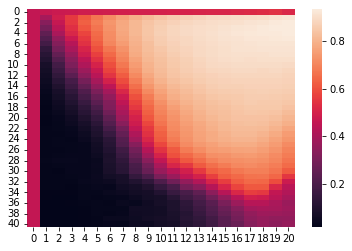

In [12]:
sns.heatmap(scores)

In [13]:
np.max(scores)

0.9325214685043762

In [17]:
results = np.where(scores > 0.93)
results

(array([2, 3, 4]), array([20, 20, 20]))